In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NIKE

dados historicos

In [42]:
data = yf.download('NKE', start='2020-01-01', end='2025-01-01')
data = data[['Close']].dropna()

[*********************100%***********************]  1 of 1 completed


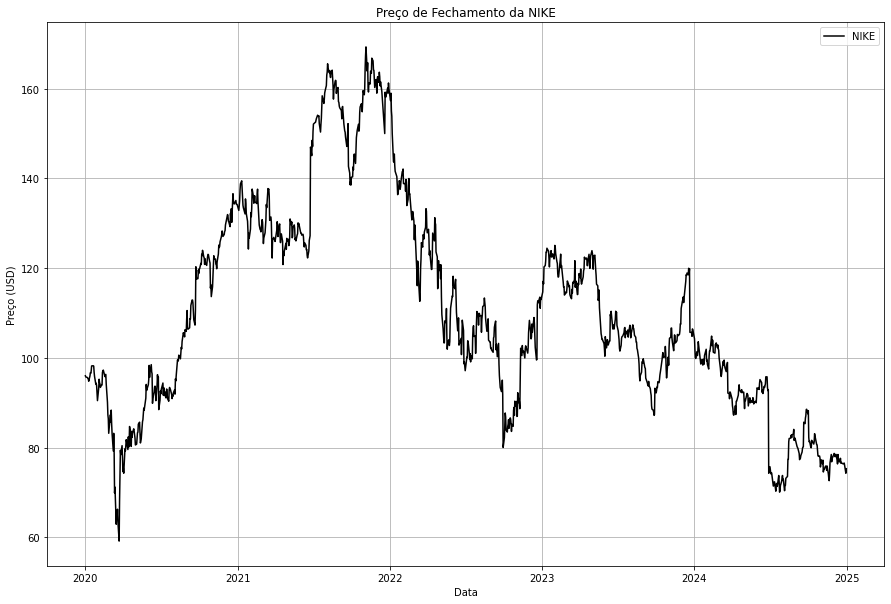

In [43]:
plt.figure(figsize=(15, 10)) 
plt.plot(data['Close'], label='NIKE', color='black', alpha=1)
plt.title('Preço de Fechamento da NIKE')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)
plt.show()

É possível perceber uma depreciação dos preços de fechamento da NIKE.

Primeiramente, vamos utilizar uma estratégia simples de Reversão à Média com Bandas de Desvio Padrão

## Reversão à media com bandas de desvio padrao:  Bandas de Bollinger

Cálculo da Média Móvel (SMA): Cálculo simples da média dos últimos 20 dias.

Desvio Padrão (STD): Mede a volatilidade em torno da média.

Com isso, devemos compra quando o preço fecha abaixo da média - k * std e vender quando o preço sobe acima da média + k * std.

In [ ]:
n = 20
k = 1

data.columns = data.columns.droplevel(1)

data['SMA'] = data['Close'].rolling(window=n).mean()
data['STD'] = data['Close'].rolling(window=n).std()

data['LowerBand'] = data['SMA'] - k * data['STD']
data['UpperBand'] = data['SMA'] + k * data['STD']

data['Signal'] = 0
data.loc[data['Close'].values < data['LowerBand'].values, 'Signal'] = 1  
data.loc[data['Close'].values > data['UpperBand'].values, 'Signal'] = -1 
data 


Price,Close,SMA,STD,LowerBand,UpperBand,Signal
Date,,,,,,
2020-01-02,96.001991,NaN,NaN,NaN,NaN,0
2020-01-03,95.738968,NaN,NaN,NaN,NaN,0
2020-01-06,95.654427,NaN,NaN,NaN,NaN,0
2020-01-07,95.607468,NaN,NaN,NaN,NaN,0
2020-01-08,95.391411,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
2024-12-24,76.403297,77.380751,0.813493,76.567258,78.194244,1
2024-12-26,76.552544,77.367026,0.825553,76.541473,78.192579,0
2024-12-27,76.035156,77.291301,0.875847,76.415454,78.167147,1


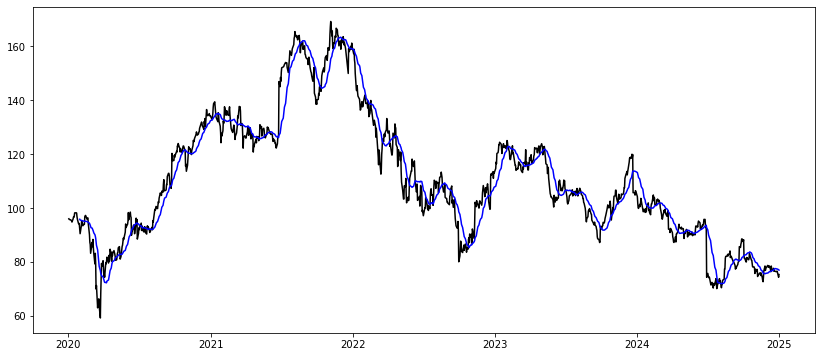

In [ ]:
plt.figure(figsize=(14,6))

# Garantir que estamos passando uma série unidimensional
plt.plot(data.index.values, data['Close'].values, label='Preço de Fechamento', color='black')

# Bandas
plt.plot(data.index.values, data['SMA'].values, label='SMA 20 dias', color='blue')


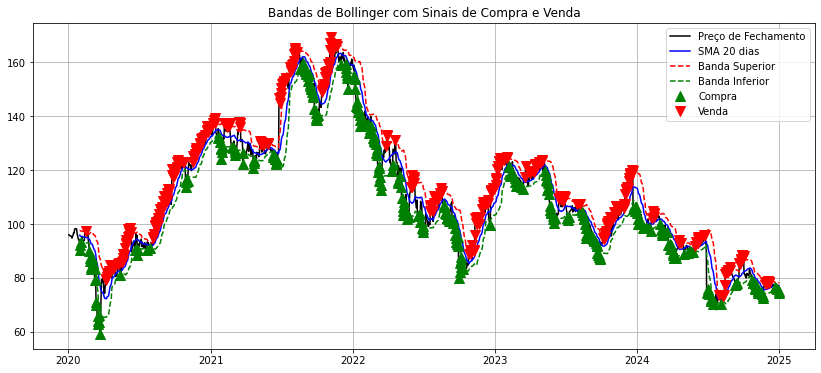

In [50]:
plt.figure(figsize=(14,6))

# Garantir que estamos passando uma série unidimensional
plt.plot(data.index.values, data['Close'].values, label='Preço de Fechamento', color='black')

# Bandas
plt.plot(data.index.values, data['SMA'].values, label='SMA 20 dias', color='blue')
plt.plot(data.index.values, data['UpperBand'].values, label='Banda Superior', color='red', linestyle='--')
plt.plot(data.index.values, data['LowerBand'].values, label='Banda Inferior', color='green', linestyle='--')

# Sinais
plt.plot(data[data['Signal'] == 1].index.values, data['Close'][data['Signal'] == 1].values, '^', markersize=10, color='green', label='Compra')
plt.plot(data[data['Signal'] == -1].index.values, data['Close'][data['Signal'] == -1].values, 'v', markersize=10, color='red', label='Venda')

plt.title('Bandas de Bollinger com Sinais de Compra e Venda')
plt.legend()
plt.grid(True)
plt.show()


## Testes de sensibilidade dos Parâmetros (n e k)

In [33]:
import numpy as np

# Faixas de parâmetros
n_values = [10, 20, 30, 50]
k_values = [0.5, 1, 1.5, 2]

results = []

for n in n_values:
    for k in k_values:
        # Cálculo das Bandas
        data['SMA'] = data['Close'].rolling(window=n).mean()
        data['STD'] = data['Close'].rolling(window=n).std()
        data['LowerBand'] = data['SMA'] - k * data['STD']
        data['UpperBand'] = data['SMA'] + k * data['STD']

        # Geração de sinais
        data['Signal'] = 0
        data.loc[data['Close'] < data['LowerBand'], 'Signal'] = 1  # Compra
        data.loc[data['Close'] > data['UpperBand'], 'Signal'] = -1  # Venda

        # Simulação simples de retorno
        data['Position'] = data['Signal'].shift(1)  # Assume entrada no dia seguinte
        data['Return'] = data['Close'].pct_change()
        data['StrategyReturn'] = data['Position'] * data['Return']

        total_return = data['StrategyReturn'].cumsum().iloc[-1]

        results.append((n, k, total_return))


In [34]:
import pandas as pd

sensitivity_df = pd.DataFrame(results, columns=['n', 'k', 'TotalReturn'])
print(sensitivity_df.pivot(index='n', columns='k', values='TotalReturn'))


k        0.5       1.0       1.5       2.0
n                                         
10 -0.025187 -0.063020 -0.111956  0.156369
20  0.103207  0.118133 -0.216140 -0.101147
30 -0.128410 -0.066987 -0.501637 -0.571978
50  0.239377  0.175929  0.165965 -0.161515


c:\Users\sergi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


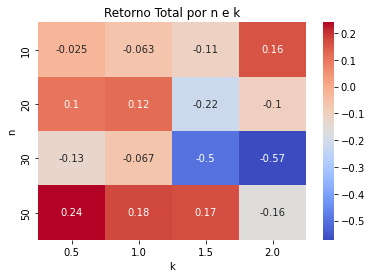

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = sensitivity_df.pivot(index='n', columns='k', values='TotalReturn')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Retorno Total por n e k')
plt.xlabel('k')
plt.ylabel('n')
plt.show()


Ou seja, os melhores resultados ocorrem quando n = 50 e k = 0.5 com retorno de 24%. 
Dessa forma, bandas mais estreitas (menor k) e um período mais longo de média funcionam para estes dados da nike.

In [52]:
n = 50
k = 0.5

#data.columns = data.columns.droplevel(1)

data['SMA'] = data['Close'].rolling(window=n).mean()
data['STD'] = data['Close'].rolling(window=n).std()

data['LowerBand'] = data['SMA'] - k * data['STD']
data['UpperBand'] = data['SMA'] + k * data['STD']

data['Signal'] = 0
data.loc[data['Close'].values < data['LowerBand'].values, 'Signal'] = 1  
data.loc[data['Close'].values > data['UpperBand'].values, 'Signal'] = -1 
data 


Price,Close,SMA,STD,LowerBand,UpperBand,Signal
Date,,,,,,
2020-01-02,96.001991,NaN,NaN,NaN,NaN,0
2020-01-03,95.738968,NaN,NaN,NaN,NaN,0
2020-01-06,95.654427,NaN,NaN,NaN,NaN,0
2020-01-07,95.607468,NaN,NaN,NaN,NaN,0
2020-01-08,95.391411,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
2024-12-24,76.403297,77.290064,2.194284,76.192922,78.387206,0
2024-12-26,76.552544,77.195284,2.118972,76.135798,78.254770,0
2024-12-27,76.035156,77.054124,1.946092,76.081077,78.027170,1


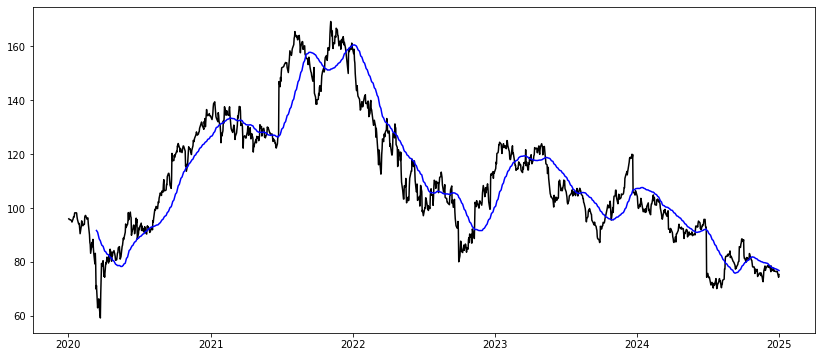

In [53]:
plt.figure(figsize=(14,6))

# Garantir que estamos passando uma série unidimensional
plt.plot(data.index.values, data['Close'].values, label='Preço de Fechamento', color='black')

# Bandas
plt.plot(data.index.values, data['SMA'].values, label='SMA 50 dias', color='blue')


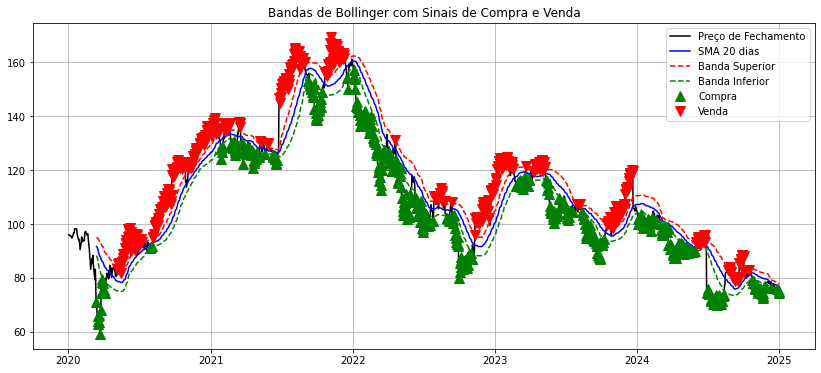

In [54]:
plt.figure(figsize=(14,6))

# Garantir que estamos passando uma série unidimensional
plt.plot(data.index.values, data['Close'].values, label='Preço de Fechamento', color='black')

# Bandas
plt.plot(data.index.values, data['SMA'].values, label='SMA 20 dias', color='blue')
plt.plot(data.index.values, data['UpperBand'].values, label='Banda Superior', color='red', linestyle='--')
plt.plot(data.index.values, data['LowerBand'].values, label='Banda Inferior', color='green', linestyle='--')

# Sinais
plt.plot(data[data['Signal'] == 1].index.values, data['Close'][data['Signal'] == 1].values, '^', markersize=10, color='green', label='Compra')
plt.plot(data[data['Signal'] == -1].index.values, data['Close'][data['Signal'] == -1].values, 'v', markersize=10, color='red', label='Venda')

plt.title('Bandas de Bollinger com Sinais de Compra e Venda')
plt.legend()
plt.grid(True)
plt.show()
